<a href="https://colab.research.google.com/github/mleonardi6/ccl-summer-2021/blob/main/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt 
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets, metrics, model_selection, svm

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Copy of IMG_5336.csv')
df2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/IMG_5334.csv')
df3 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/DF.csv')
au= pd.concat([df[' timestamp'], df.iloc[:,-35:-18]], axis = 1)
df3 = df3.loc[:,df3.columns.str.contains('_r|Elaborated|Hypothesizing')]
df3 = df3.loc[:,df3.columns.str.contains('AU|Elaborated|Hypothesizing')]
df3 = df3.fillna(0)
df2 = df2.loc[:,df2.columns.str.contains('_r|Elaborated|Hypothesizing')]
df2 = df2.loc[:,df2.columns.str.contains('AU|Elaborated|Hypothesizing')]
df2 = df2.fillna(0)
df = df.loc[:,df.columns.str.contains('_r|Elaborated|Hypothesizing')]
df = df.loc[:,df.columns.str.contains('AU|Elaborated|Hypothesizing')]
df = df.fillna(0)
dfo = pd.concat([df3,df,df2])
dfo.fillna(0)
dfo = dfo.reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (719,722,723,724,726,727) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dfo.shape

(168738, 19)

In [5]:
x = dfo.loc[:,dfo.columns.str.contains('AU')]
y = dfo.loc[:,dfo.columns.str.contains('Elaborated')]
data_dmatrix = xgb.DMatrix(data=x,label=y)

In [6]:
dfo = dfo.fillna(0)
x_train, x_test, y_train, y_test = train_test_split(dfo.drop(['Elaborated','Hypothesizing'], axis = 'columns'), dfo.Elaborated, test_size = 0.3)

In [7]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(x_train,y_train)
preds = xg_reg.predict(x_test)
for i in range(len(preds)):
  if preds[i] >= .33:
    preds[i] = 1
  else:
    preds[i] = 0
preds

[16:34:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0., 0., 1., ..., 0., 1., 1.], dtype=float32)

In [8]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.44%


I adjusted the parameters for a 'elaborated' prediction to be a value >= 0.33 generated by the xgboost model. This produced a much higher accuracy predicting 1s for 'Elaborated', around 62%. Lowering the parameter increases the accuracy for 1s, but lowers it for 0s. 

Text(69.0, 0.5, 'Truth')

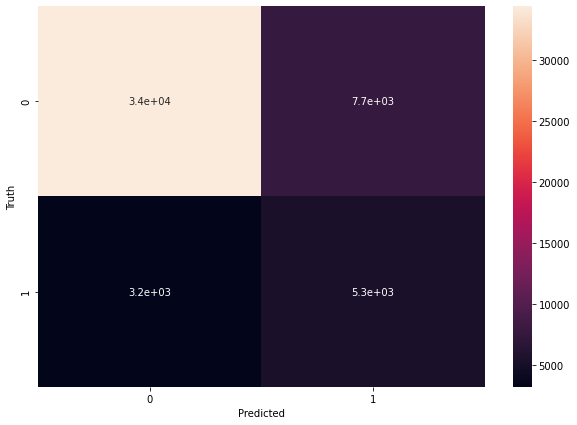

In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, preds)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

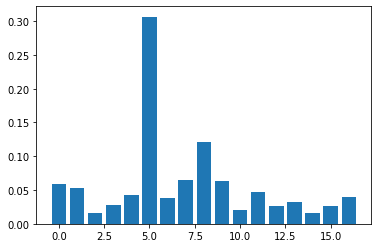

In [10]:
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

In [11]:
for col in dfo.columns:
    print(col)

 AU01_r
 AU02_r
 AU04_r
 AU05_r
 AU06_r
 AU07_r
 AU09_r
 AU10_r
 AU12_r
 AU14_r
 AU15_r
 AU17_r
 AU20_r
 AU23_r
 AU25_r
 AU26_r
 AU45_r
Elaborated
Hypothesizing


AU_7 is most important, looks like AU_04, AU_15 and AU_25 are least important. Going to try with the most important half of features below.

In [12]:
selection = SelectFromModel(xg_reg, threshold=0.05, prefit=True)
select_X_train = selection.transform(x_train)
# train model
selection_model = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(x_test)
y_pred = selection_model.predict(select_X_test)


[16:34:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [13]:
y_pred = selection_model.predict(select_X_test)
for i in range(len(y_pred)):
  if y_pred[i] >= .31:
    y_pred[i] = 1
  else:
    y_pred[i] = 0
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.14%


Text(69.0, 0.5, 'Truth')

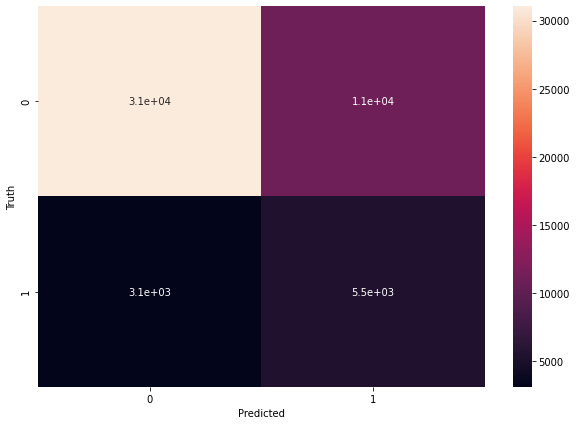

In [14]:
cm = confusion_matrix(y_test, y_pred)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

Not sure if this really increased the accuracy, had to lower the parameter to .31 to get the elaborated accuracy over 50%.

ROC Curve

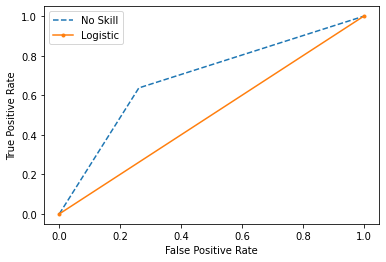

In [24]:
ns = [0 for _ in range(len(y_test))]
plt.figure
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred)
lr_fpr, lr_tpr, _ = roc_curve(y_test, ns)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()